In [1]:
from min30_zeroInf_negative_Binomial import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import *
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential

Num GPUs: 1


Using TensorFlow backend.


In [2]:
source_model,modelpath,train,test = getModel(False)
source_model.summary()
predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 20)   920         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 20)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 20)   0           activation[0][0]                 
______________________________________________________________________________________________

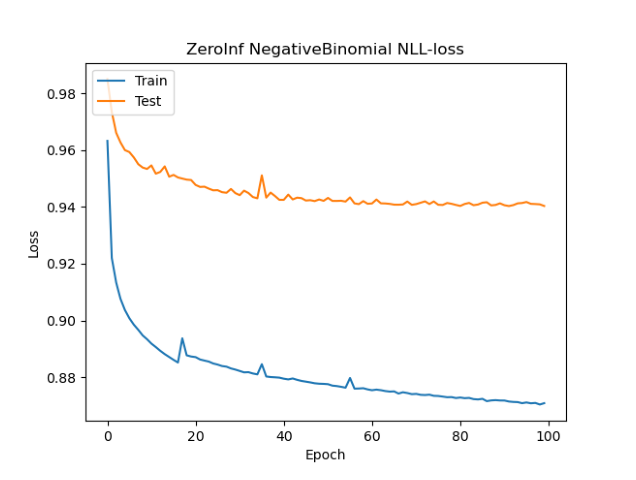

In [3]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()
y_transform = [cutOut([16,80,16,80])]

In [4]:
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
model.load_weights(laststate["modelpath"])
test.setWiggle_off()

In [5]:
def getFreshSet(batch_size=1):
    #x_transform = [Normalize(0.007742631458799244, 0.015872015890555563 )]
    
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=30,
                         y_transform=y_transform)
    return train,test

In [6]:
from Models.Distributions import ZeroInflated_Binomial
pred = None
label = None
pred = 20
#test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)

test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if i < 10:
            continue
        pred = model(np.array([x[i,:,:,:]]))
        pred = ZeroInflated_Binomial()(pred)
        mean.append(pred.mean())
        stdev.append(pred.stddev())
        label.append(y[i,:,:,:])
        predictions.append((pred,y[i:,:,:]))
        atm.append(x[i,:,:,-1:])
        if len(label) == 20:
            break
    break
    if len(label) == 20:
                break

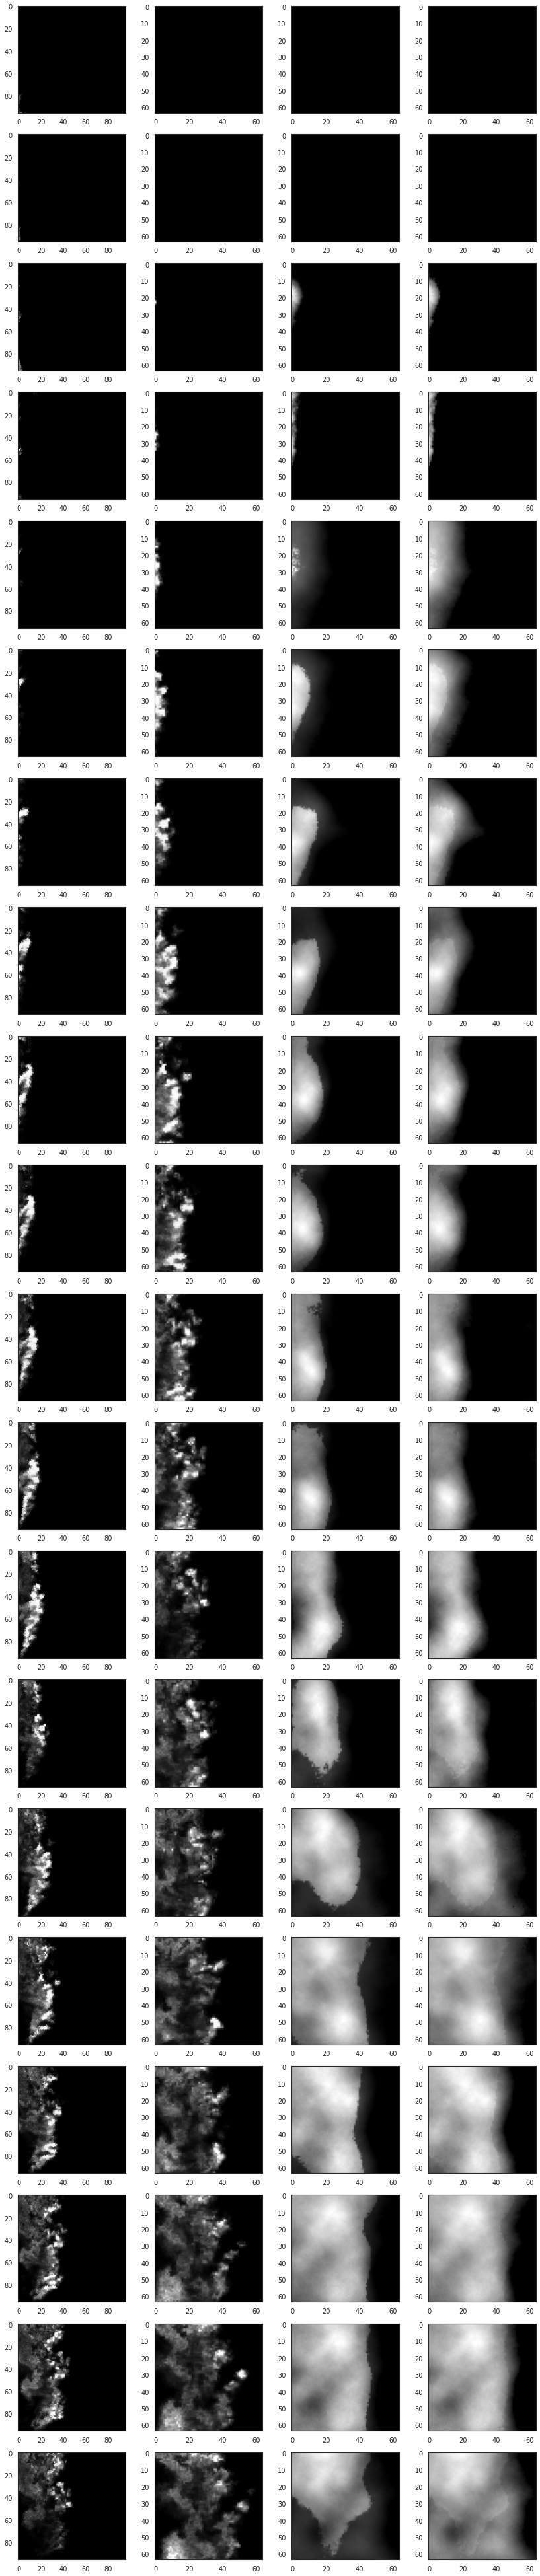

In [7]:
sns.set(style="white")
#sns.set_style("darkgrid")
fig, axes = plt.subplots(20, 4, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,2].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,3].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,1].imshow(label[batch][:,:,0],cmap="gray")
    axes[batch,0].imshow(atm[batch][:,:,-1],cmap="gray")
plt.show()

In [8]:
train,test =  getFreshSet(batch_size=100)

In [9]:
baseline = multiProc_eval(model,test,getFreshSet,x_transform=y_transform)

Worker  0 finishedd   2200 imagesing to sleep for 5s
Worker  3 finishedd   2200 images
Worker  4 finishedd   2200 imagesing to sleep for 5s
Worker  7 finishedd   2200 imagesing to sleep for 5s
Worker  2 finishedd   2200 images
Worker  6 finishedd   2200 images
Worker  1 finishedd   2200 images
Worker 10 finishedd   2200 images
Worker  9 finishedd   2200 images
Worker 11 finishedd   2200 imagesing to sleep for 5s
Worker  5 finishedd   2200 images
Worker  8 finishedd   2200 imagesing to sleep for 5s
Worker 13 finishedd   2200 imagesing to sleep for 5s
Worker 12 finishedd   2200 images
Worker 15 finishedd   2200 images
Worker 14 finishedd   2200 images
Worker 17 finishedd   2200 imagesing to sleep for 5s
Worker 16 finishedd   2200 images
Worker 18 finishedd   2200 imagesing to sleep for 5s
Worker 20 finishedd   2200 images
Worker 19 finishedd   2200 imagesing to sleep for 5s
Worker 21 finishedd   2200 images
Worker 24 finishedd   2200 imagesing to sleep for 5s
Worker 22 finishedd   2200 i

<Figure size 2000x3000 with 0 Axes>

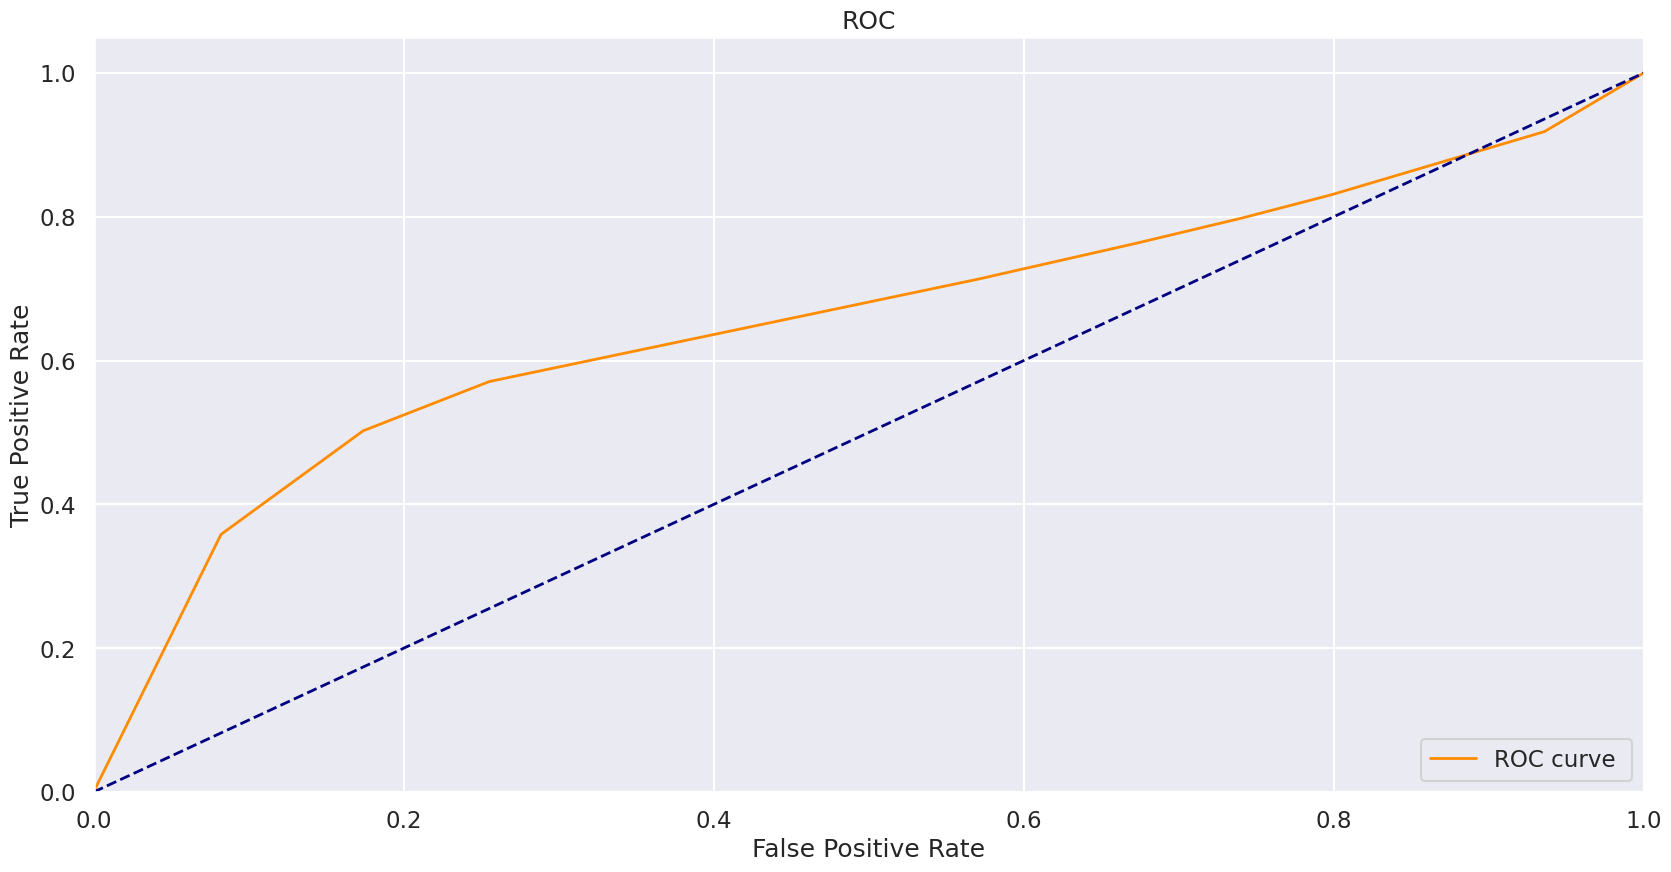

In [10]:
baseline_dict = baseline.copy()
plotAUC(baseline_dict)

In [11]:

ret = calculate_quantiles(model,test,cfdi=0.99)
q,l = ret

/home/simon/anaconda3/envs/DeepRain/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


<Figure size 2000x1000 with 0 Axes>

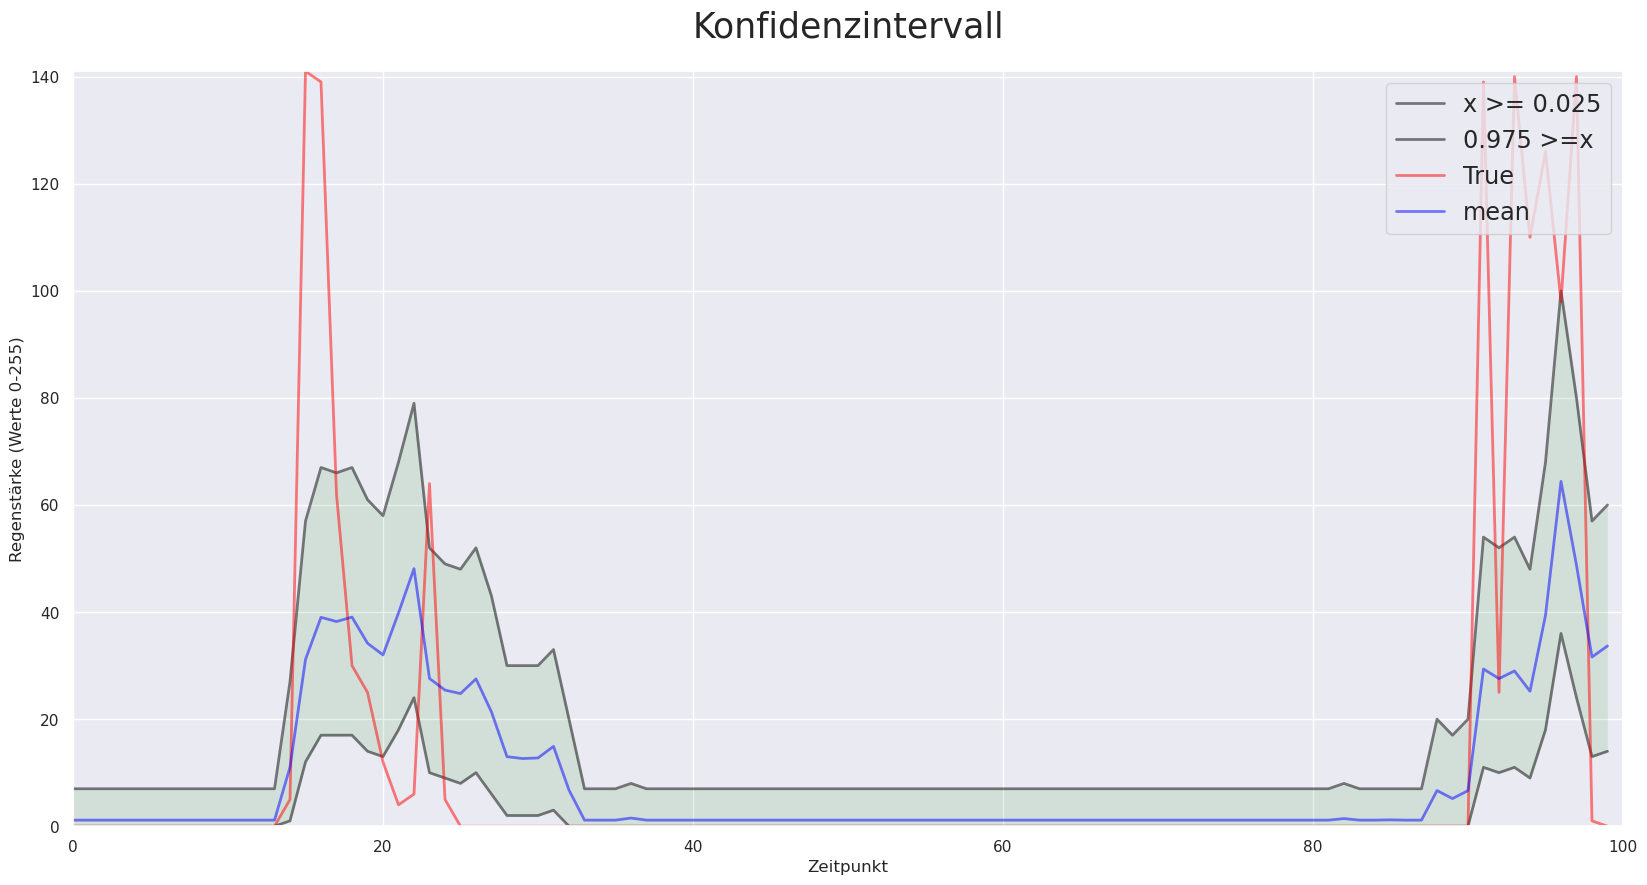

In [22]:
def plotCFDI(q,l):
    x,y = np.random.randint(low=0,high=q[0].shape[1],size=2)
    
    lower = []
    upper = []
    mean  = []
    label = []
    
    for i in range(len(q)):
        lower.append(q[i][0,x,y,0])
        mean.append(q[i][0,x,y,1])
        upper.append(q[i][0,x,y,2])
        label.append(l[i][x,y,0])
        
    x = np.arange(len(lower))
    
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10),dpi=100)
    fig, ax = plt.subplots(1, 1,figsize=(20, 10),dpi=100, sharex=True)
    
    size=25
    lw = 2
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size,
              'ytick.labelsize': size,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    
    ax.plot(x, lower,color='black',label="x >= 0.025",alpha = 0.5,lw=lw)
    ax.plot(x, upper, color='black',label="0.975 >=x",alpha = 0.5,lw=lw)
    ax.plot(x, label, color='red',label="True",alpha = 0.5,lw=lw)
    ax.plot(x, mean, color='blue',label="mean",alpha = 0.5,lw=lw)
    plt.legend(loc="upper right")
    ax.fill_between(x, lower, upper, where=upper >= lower, facecolor='green', alpha=0.1,interpolate=True)
    ax.set_title('Konfidenzintervall')
    plt.ylim([0.0, np.max( (np.max(label),np.max(upper)) )])
    plt.xlim([0, len(q)])
    plt.ylabel('Regenstärke (Werte 0-255)')
    plt.xlabel('Zeitpunkt')
plotCFDI(q[0:100],l[0:100])


In [13]:
hist,hist_q = histogramm(q,l)


# Wie oft liegen wir im 90% quantil?

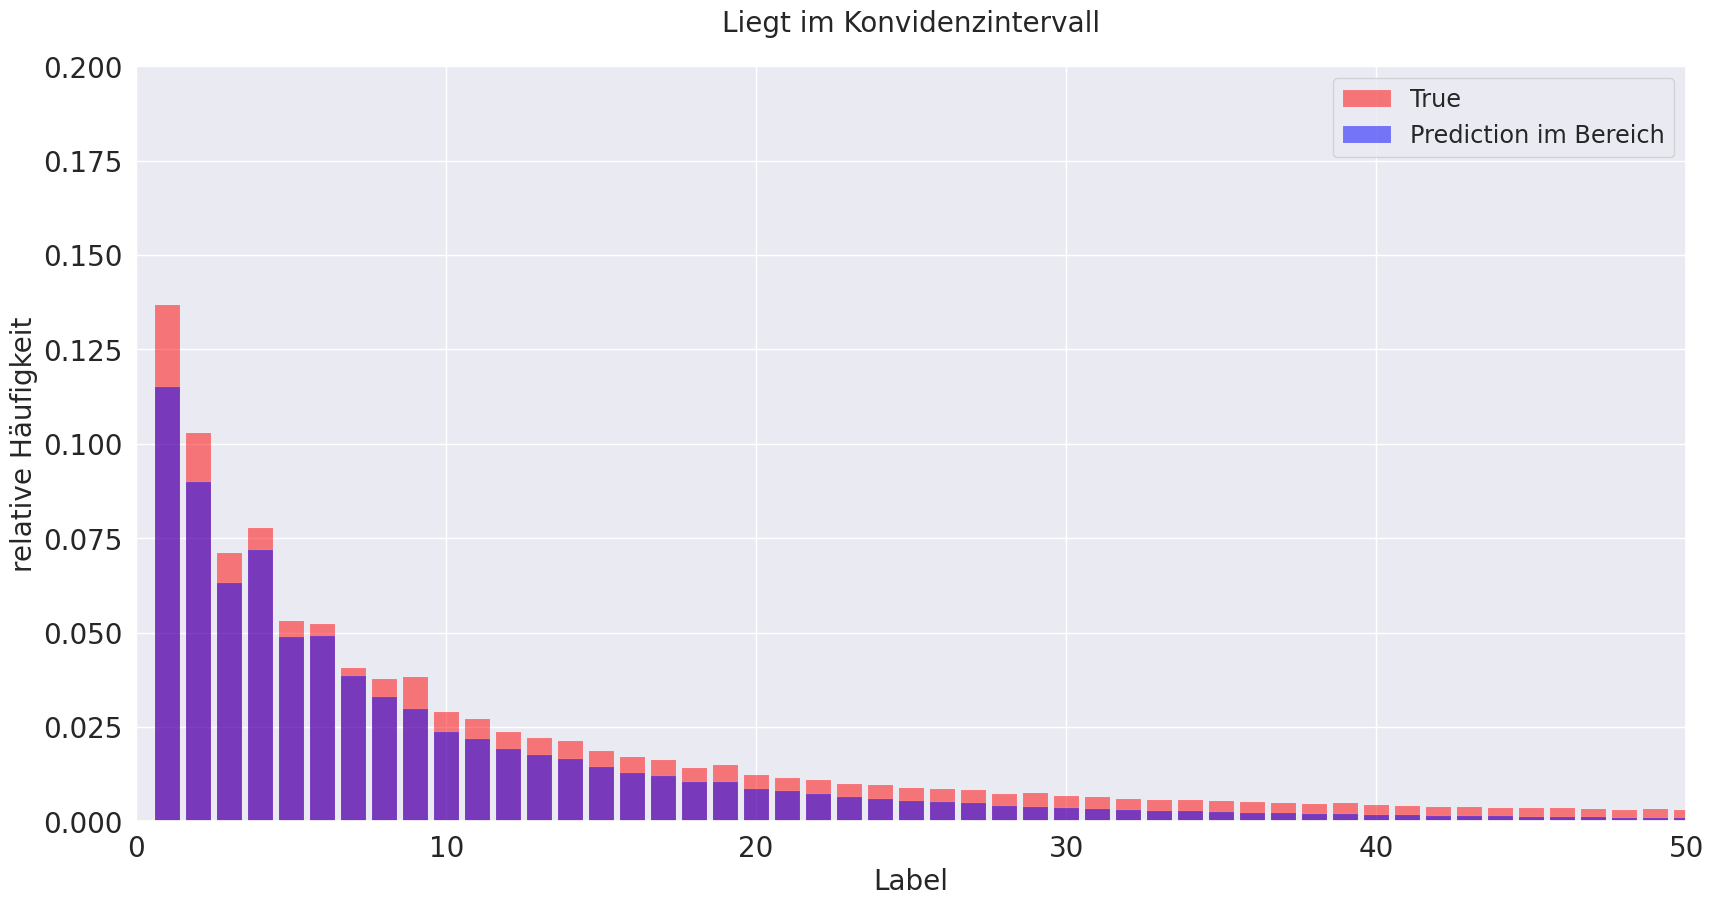

In [14]:
def plotHist(hist,hist_q):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors
    from matplotlib.ticker import PercentFormatter
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10),dpi=100)

    size=20
    lw = 3
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size,
              'ytick.labelsize': size,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    
    hist_n = hist / hist[1:50].sum()
    plt.title('Liegt im Konvidenzintervall')
    plt.bar(np.arange(1,51),hist_n[1:51],color="red",alpha=0.5,lw=.1,label="True")
    plt.ylim([0.0, 0.2])
    plt.xlim([0, 50])
    plt.xlabel('Label')
    plt.ylabel('relative Häufigkeit')
    #plt.show()

    hist_q_n = hist_q / hist[1:50].sum()
    plt.bar(np.arange(1,51),hist_q_n[1:51],color="blue",alpha=0.5,lw=.1,label="Prediction im Bereich")
    plt.ylim([0.0, 0.2])
    plt.xlim([0, 50])
    plt.legend(loc="upper right")
    plt.show()


plotHist(hist,hist_q)

In [15]:
print("Anzahl an labels           :",hist.sum())
print("Anzahl liegt im C-Intervall {} | {:.2f}:".format(hist_q.sum(),hist_q.sum()/hist.sum()))
print("\nOhne Regen")
print("Anzahl an labels           :",hist[1:].sum())
print("Anzahl liegt im C-Intervall: {} | {:.2f}%".format(hist_q[1:].sum(),hist_q[1:].sum()/hist[1:].sum()))

Anzahl an labels           : 12288000.0
Anzahl liegt im C-Intervall 11444741.0 | 0.93:

Ohne Regen
Anzahl an labels           : 1655721.0
Anzahl liegt im C-Intervall: 1219020.0 | 0.74%


Parameter : 0.50


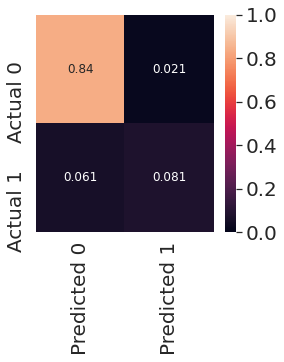

Simple Baseline


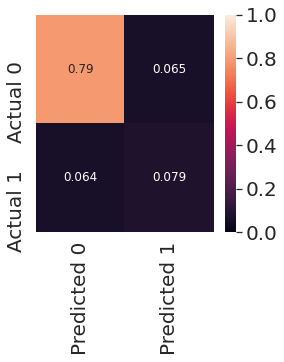

10


In [16]:
def plotConfusionMat(baseline,t):
    
    
    print("Parameter : {:.2f}".format(t/20))
    baseline = baseline[t]
    false_neg = baseline["FN"]
    false_pos = baseline["FP"]
    true_pos = baseline["TP"]
    true_neg = baseline["TN"]
    
    simple_false_neg = baseline["FN_simple"]
    simple_false_pos = baseline["FP_simple"]
    simple_true_pos = baseline["TP_simple"]
    simple_true_neg = baseline["TN_simple"]
    
    
    plt.figure(figsize = (4,4))

    #mat = np.array([[false_neg.sum(),false_pos.sum()],[true_neg.sum(),true_pos.sum()]])
    mat = np.array([[true_neg.sum(),false_pos.sum()],[false_neg.sum(),true_pos.sum()]])
    total = mat.sum()
    df_cm = pd.DataFrame(mat/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
    sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
    plt.show()
    
    plt.figure(figsize = (4,4))
    print("Simple Baseline")
    mat_simple = np.array([[simple_true_neg.sum(),simple_false_pos.sum()],[simple_false_neg.sum(),simple_true_pos.sum()]])
    total = mat.sum()
    df_cm = pd.DataFrame(mat_simple/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
    sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
    plt.show()

    print(len(baseline))
    
plotConfusionMat(baseline_dict,t=10)

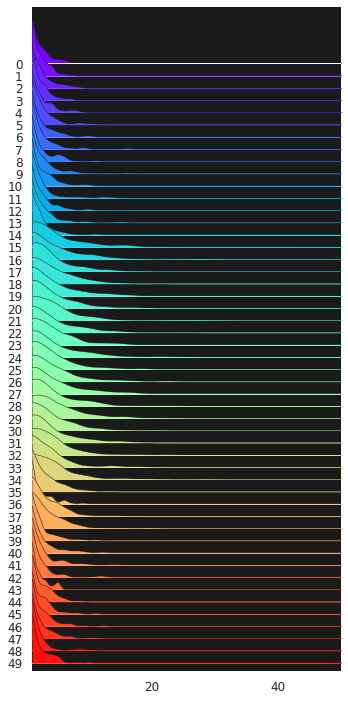

In [17]:


def nBinom(t):
    
    return tfp.distributions.Independent(
                    tfp.distributions.NegativeBinomial(
                    total_count=tf.math.softplus(t[...,1:]), \
                    logits=tf.math.sigmoid(t[...,:1]))
        ,name="ZeroInflated_Binomial",reinterpreted_batch_ndims=0)


def getDist(param,dist,iv=(0,255)):
    prediction = dist(param)
    prob = np.array(prediction.sample(255))
    prob = prob.transpose(1,2,3,4,0)
    
    return prob[:,:,:,0,:]
    

def joyplot(model,test,max_j = 2):
    y = test[0][1]
    x_,y_ = np.random.randint(low=0,high=y.shape[1],size=2)

    dists = []
    time_d  = []
    x_series = []

    for j,(x,y) in enumerate(test):
        
        if j >= max_j:
            break
        batch_size = x.shape[0]
        for i in range(batch_size):
            pred = model(np.array([x[i,:,:,:]]))
            d = getDist(pred[:,:,:,1:],nBinom)
            dists.append(np.array(d[0,x_,y_,1:]))
            x_series.append(np.arange(0,255))
            
    import joypy
    dframe = pd.DataFrame(np.array(dists[:50]).T)
    fig, axes = joypy.joyplot(dframe,
                              figsize=(5,10),
                              linewidth=0.5,
                              grid='y',
                              background='k',
                              x_range=[1,50],
                              colormap=cm.rainbow)
    plt.show()
    
joyplot(model,test)

In [18]:
from Utils.transform import LogBin
logbin = LogBin()
q_a = []
l_a = []


output_dist = tfp.layers.DistributionLambda(
        name="DistributionLayer",
        make_distribution_fn=lambda t: tfp.distributions.Independent(
        tfd.Mixture(
            cat=tfd.Categorical(tf.stack([1-tf.math.sigmoid(t[...,:1]), tf.math.sigmoid(t[...,:1])],axis=-1)),
            components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
            tfp.distributions.NegativeBinomial(
            total_count=tf.math.softplus(t[..., 1:2]), 
            logits=tf.math.sigmoid(t[..., 2:]) ),])
        ,name="ZeroInflated_Binomial",reinterpreted_batch_ndims=0 ))

train,test =  getFreshSet(batch_size=1) 
for j,(x,y) in enumerate(test):
    batch_shape = x.shape[0]
    pred = model(x)
    pred = output_dist(pred)
    l_a.append(logbin(y))
    
    p = np.array(pred.mean())
    p[np.where(p < 1)] = 0
    
    q_a.append(logbin(p))
    print(j,end="\r")
    if j == 2500:
        break

In [19]:



def histogramm(q,l,last=3,m_labels=256):
    
    _,x,y,_ = q[0].shape
    
    hist = np.zeros(m_labels)
    hist_q = hist.copy()
        
    for i,d in enumerate(q):
        label = l[i]
        label = label.ravel()
        d = d.reshape(x*y,last)
        for j in range(x*y):
            hist[int(label[j])] += 1
            v = label[j]
            if d[j][0] <= v and d[j][-1] >= v:
                hist_q[int(label[j])] += 1
    return hist,hist_q
hist,hist_q = histogramm(q_a,l_a,last=1,m_labels=7)

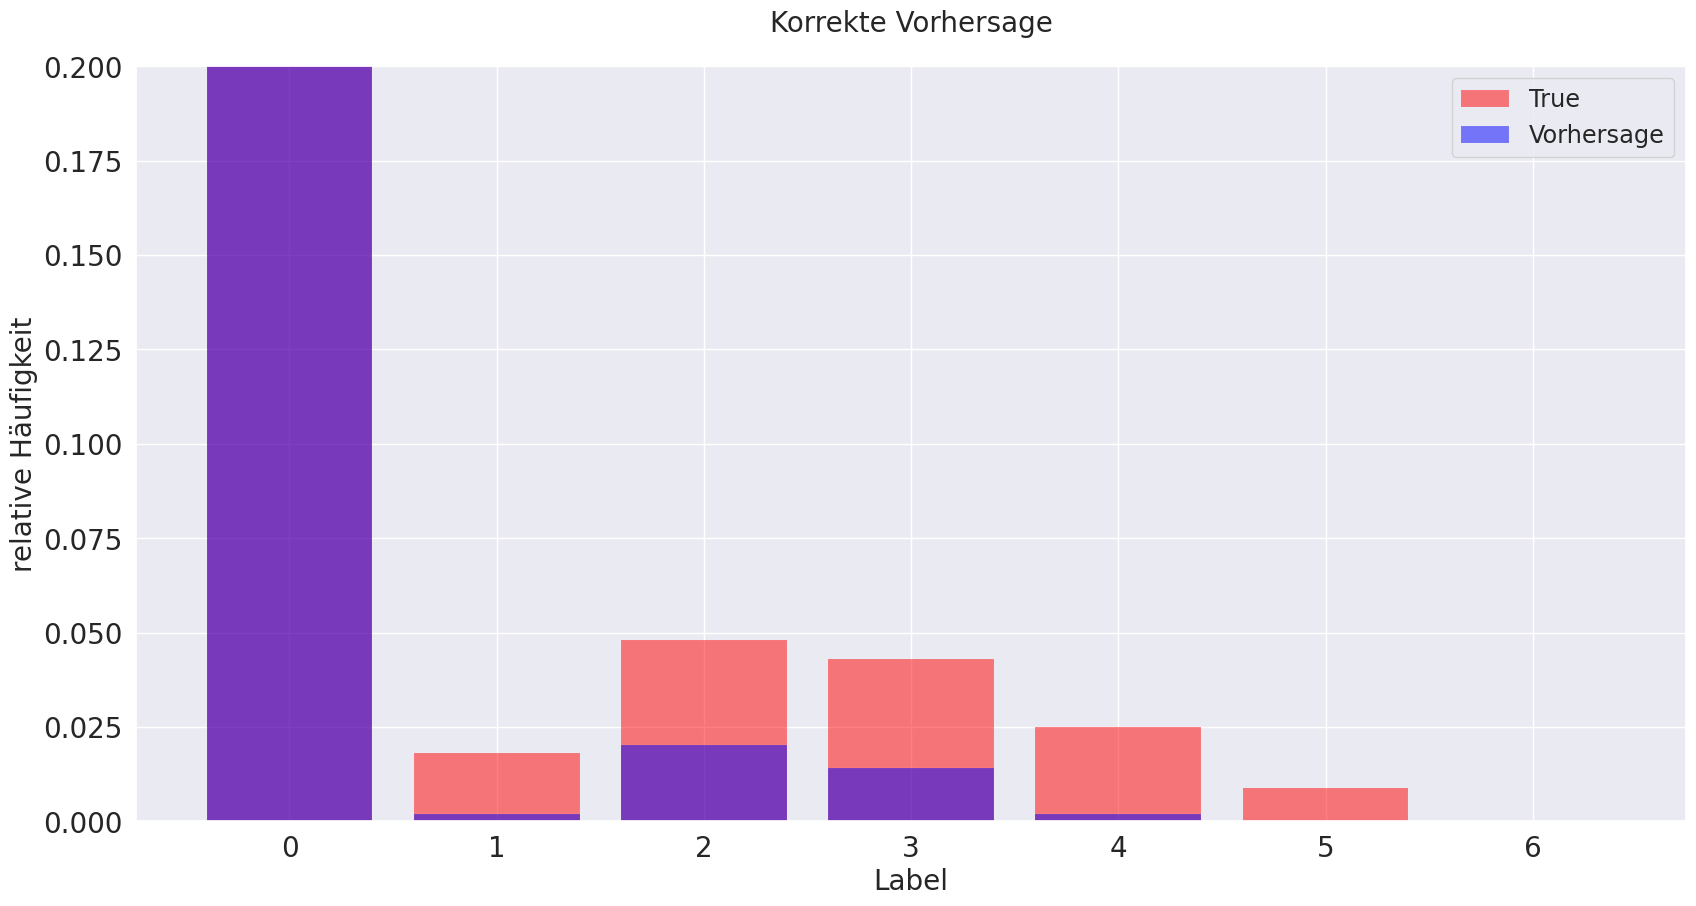

In [20]:
def plotHist(hist,hist_q,min_ = 1,max_=50,title='Liegt im Quantil'):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors
    from matplotlib.ticker import PercentFormatter
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10),dpi=100)
    
    size=20
    lw = 3
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size,
              'ytick.labelsize': size,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    hist_n = hist / hist[min_:max_].sum()
    plt.title(title)
    plt.bar(np.arange(min_,max_+1),hist_n[min_:max_+1],color="red",alpha=0.5,lw=.1,label="True")
    plt.ylim([0.0, 0.2])
    #plt.xlim([min_, max_])
    plt.xlabel('Label')
    plt.ylabel('relative Häufigkeit')
    #plt.show()

    hist_q_n = hist_q / hist[min_:max_].sum()
    plt.bar(np.arange(min_,max_+1),hist_q_n[min_:max_+1],color="blue",alpha=0.5,lw=.1,label="Vorhersage")
    plt.ylim([0.0, 0.2])
    #plt.xlim([min_, max_+1])
    plt.legend(loc="upper right")
    plt.show()
plotHist(hist,hist_q,min_=0,max_=6,title="Korrekte Vorhersage")

In [21]:
someStats(hist,hist_q)

Anzahl an labels           : 10244096.0
Anzahl liegt im C-Intervall 8020071.0 | 0.78:

Ohne Regen
Anzahl an labels           : 1462356.0
Anzahl liegt im C-Intervall: 389727.0 | 0.27%
